In [1]:
import torch
from torch_geometric.data import Data
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [2]:
fileset = {}

sig_dir = '/ceph/cms/store/user/aaportel/B-Parking/rechits_v2/BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300/'
fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}.root' for i in range(328)]
# fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}.root' for i in range(2)]

# bkg_dir = '/ceph/cms/store/user/aaportel/B-Parking/rechits_v2/ParkingBPH1_2018A/'
# fileset['background'] = [bkg_dir + f'ParkingBPH1_2018A_{str(i).zfill(7)}.root' for i in range(380)]

In [3]:
def process_files(file, k_value):
    f = uproot.open(file)
    raw_data = f['MuonSystem'].arrays(library = 'ak')
    
    cluster_mask = ak.num(raw_data.cscRechitClusterX) > 0
    rechit_mask = ak.num(raw_data.cscRechitsX) > 0
    
    intersection_mask = cluster_mask & rechit_mask
    
    raw_data = raw_data[intersection_mask]
    
    ids = raw_data.cscRechitClusterSegmentID[raw_data.cscRechitClusterSegmentID!=-999]

    def clusterer(data, ids):
        clustered = []
        for i in range(len(ids)):
            clusters = []
            for id in ids[i]:
                clusters.append(data[i][id])
            clustered.append(clusters)    
        return ak.flatten(ak.Array(clustered), axis = 1)
    
    cscRechits_clustered = ak.zip({
        "Phi": clusterer(raw_data.cscRechitsPhi, ids),
        "Eta": clusterer(raw_data.cscRechitsEta, ids),
        "X": clusterer(raw_data.cscRechitsX, ids),
        "Y": clusterer(raw_data.cscRechitsY, ids),
        "Z": clusterer(raw_data.cscRechitsZ, ids),
        "E": clusterer(raw_data.cscRechitsE, ids),
        "Tpeak": clusterer(raw_data.cscRechitsTpeak, ids),
        "Twire": clusterer(raw_data.cscRechitsTwire, ids),
        "Quality": clusterer(raw_data.cscRechitsQuality, ids),
        "Chamber": clusterer(raw_data.cscRechitsChamber, ids),
        "Station": clusterer(raw_data.cscRechitsStation, ids),
        "Channels": clusterer(raw_data.cscRechitsChannels, ids),
        "NStrips": clusterer(raw_data.cscRechitsNStrips, ids),
        "HitWire": clusterer(raw_data.cscRechitsHitWire, ids),
        "WGroupsBX": clusterer(raw_data.cscRechitsWGroupsBX, ids),
        "NWireGroups": clusterer(raw_data.cscRechitsNWireGroups, ids),
        "DetId": clusterer(raw_data.cscRechitsDetId, ids),
    })
    
    cscRechitClusters = ak.zip({
        "X": ak.flatten(raw_data.cscRechitClusterX, axis = 1),
        "Y": ak.flatten(raw_data.cscRechitClusterY, axis = 1),
        "Z": ak.flatten(raw_data.cscRechitClusterZ, axis = 1),
        "Time": ak.flatten(raw_data.cscRechitClusterTime, axis = 1),
        "TimeWeighted": ak.flatten(raw_data.cscRechitClusterTimeWeighted, axis = 1),
        "TimeTotal": ak.flatten(raw_data.cscRechitClusterTimeTotal, axis = 1),
        "TimeSpread": ak.flatten(raw_data.cscRechitClusterTimeSpread, axis = 1),
        "TimeSpreadWeighted": ak.flatten(raw_data.cscRechitClusterTimeSpreadWeighted, axis = 1),
        "TimeSpreadWeightedAll": ak.flatten(raw_data.cscRechitClusterTimeSpreadWeightedAll, axis = 1),
        "GenMuonDeltaR": ak.flatten(raw_data.cscRechitClusterGenMuonDeltaR, axis = 1),
        "Phi": ak.flatten(raw_data.cscRechitClusterPhi, axis = 1),
        "Eta": ak.flatten(raw_data.cscRechitClusterEta, axis = 1),
        "Size": ak.flatten(raw_data.cscRechitClusterSize, axis = 1),
        "Me11Ratio": ak.flatten(raw_data.cscRechitClusterMe11Ratio, axis = 1),
        "Me12Ratio": ak.flatten(raw_data.cscRechitClusterMe12Ratio, axis = 1),
        "NStation": ak.flatten(raw_data.cscRechitClusterNStation, axis = 1),
        "NStation5": ak.flatten(raw_data.cscRechitClusterNStation5, axis = 1),
        "NStation10": ak.flatten(raw_data.cscRechitClusterNStation10, axis = 1),
        "NStation10perc": ak.flatten(raw_data.cscRechitClusterNStation10perc, axis = 1),
        "AvgStation": ak.flatten(raw_data.cscRechitClusterAvgStation, axis = 1),
        "AvgStation5": ak.flatten(raw_data.cscRechitClusterAvgStation5, axis = 1),
        "AvgStation10": ak.flatten(raw_data.cscRechitClusterAvgStation10, axis = 1),
        "AvgStation10perc": ak.flatten(raw_data.cscRechitClusterAvgStation10perc, axis = 1),
        "MatchedTrackSumPt_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_0p2, axis = 1),
        "MatchedTrackLeadPt_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_0p2, axis = 1),
        "MatchedTrackSize_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_0p2, axis = 1),
        "MatchedTrackSumPt_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_0p3, axis = 1),
        "MatchedTrackLeadPt_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_0p3, axis = 1),
        "MatchedTrackSize_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_0p3, axis = 1),
        "MatchedTrackSumPt_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_0p4, axis = 1),
        "MatchedTrackLeadPt_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_0p4, axis = 1),
        "MatchedTrackSize_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_0p4, axis = 1),
        "MatchedTrackSumPt_trk_pos_0p5": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_trk_pos_0p5, axis = 1),
        "MatchedTrackLeadPt_trk_pos_0p5": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_trk_pos_0p5, axis = 1),
        "MatchedTrackSize_trk_pos_0p5": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_trk_pos_0p5, axis = 1),
        "MatchedTrackSumPt_trk_pos_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_trk_pos_0p2, axis = 1),
        "MatchedTrackLeadPt_trk_pos_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_trk_pos_0p2, axis = 1),
        "MatchedTrackSize_trk_pos_0p2": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_trk_pos_0p2, axis = 1),
        "MatchedTrackSumPt_trk_pos_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_trk_pos_0p3, axis = 1),
        "MatchedTrackLeadPt_trk_pos_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_trk_pos_0p3, axis = 1),
        "MatchedTrackSize_trk_pos_0p3": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_trk_pos_0p3, axis = 1),
        "MatchedTrackSumPt_trk_pos_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackSumPt_trk_pos_0p4, axis = 1),
        "MatchedTrackLeadPt_trk_pos_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackLeadPt_trk_pos_0p4, axis = 1),
        "MatchedTrackSize_trk_pos_0p4": ak.flatten(raw_data.cscRechitClusterMatchedTrackSize_trk_pos_0p4, axis = 1),
        "MaxStation": ak.flatten(raw_data.cscRechitClusterMaxStation, axis = 1),
        "MaxStationRatio": ak.flatten(raw_data.cscRechitClusterMaxStationRatio, axis = 1),
        "NChamber": ak.flatten(raw_data.cscRechitClusterNChamber, axis = 1),
        "MaxChamber": ak.flatten(raw_data.cscRechitClusterMaxChamber, axis = 1),
        "MaxChamberRatio": ak.flatten(raw_data.cscRechitClusterMaxChamberRatio, axis = 1),
        "NRechitChamberPlus11": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus11, axis = 1),
        "NRechitChamberPlus12": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus12, axis = 1),
        "NRechitChamberPlus13": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus13, axis = 1),
        "NRechitChamberPlus21": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus21, axis = 1),
        "NRechitChamberPlus22": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus22, axis = 1),
        "NRechitChamberPlus31": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus31, axis = 1),
        "NRechitChamberPlus32": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus32, axis = 1),
        "NRechitChamberPlus41": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus41, axis = 1),
        "NRechitChamberPlus42": ak.flatten(raw_data.cscRechitClusterNRechitChamberPlus42, axis = 1),
        "NRechitChamberMinus11": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus11, axis = 1),
        "NRechitChamberMinus12": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus12, axis = 1),
        "NRechitChamberMinus13": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus13, axis = 1),
        "NRechitChamberMinus21": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus21, axis = 1),
        "NRechitChamberMinus22": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus22, axis = 1),
        "NRechitChamberMinus31": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus31, axis = 1),
        "NRechitChamberMinus32": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus32, axis = 1),
        "NRechitChamberMinus41": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus41, axis = 1),
        "NRechitChamberMinus42": ak.flatten(raw_data.cscRechitClusterNRechitChamberMinus42, axis = 1),
        "_match_dtSeg_0p4": ak.flatten(raw_data.cscRechitCluster_match_dtSeg_0p4, axis = 1),
        "_match_MB1Seg_0p4": ak.flatten(raw_data.cscRechitCluster_match_MB1Seg_0p4, axis = 1),
        "_match_RB1_0p4": ak.flatten(raw_data.cscRechitCluster_match_RB1_0p4, axis = 1),
        "_match_RE12_0p4": ak.flatten(raw_data.cscRechitCluster_match_RE12_0p4, axis = 1),
        "_match_gLLP_deltaR": ak.flatten(raw_data.cscRechitCluster_match_gLLP_deltaR, axis = 1),
        "JetVetoPt": ak.flatten(raw_data.cscRechitClusterJetVetoPt, axis = 1),
        "MuonVetoPt": ak.flatten(raw_data.cscRechitClusterMuonVetoPt, axis = 1),
        "GenMuonVetoPt_dR0p8": ak.flatten(raw_data.cscRechitClusterGenMuonVetoPt_dR0p8, axis = 1),
        "GenMuonVetoPt": ak.flatten(raw_data.cscRechitClusterGenMuonVetoPt, axis = 1),
        "MetEENoise_dPhi": ak.flatten(raw_data.cscRechitClusterMetEENoise_dPhi, axis = 1),
        
    })

    def deltaR(eta1, phi1, eta2, phi2):
        deta = eta1 - eta2
        dphi = np.arctan2(np.sin(phi1 - phi2), np.cos(phi1 - phi2))
        return np.sqrt(deta**2 + dphi**2)
    
    labels = ak.flatten(
            deltaR(raw_data.cscRechitClusterEta, raw_data.cscRechitClusterPhi, raw_data.gLLP_eta, raw_data.gLLP_phi) < .8, 
        axis = 1)
        
    graph_data_list = []
    
    # Combine x, y, and z coordinates and create graph objects
    for rechit, cluster, label in zip(cscRechits_clustered, cscRechitClusters, labels):
        # Combine x, y, and z into a single tensor of node features
        node_features = torch.tensor([rechit[thing] for thing in rechit.fields], dtype=torch.float).t()
        
        # Define your edge_index here; placeholder for demonstration purposes
        # For a fully connected graph, every node would be connected to every other node
        # This is likely not what you want, but without more information, this is a simple placeholder

        selected_node_features = node_features[:, 2:4]

        nbrs = NearestNeighbors(n_neighbors=k_value+1, algorithm='ball_tree', metric='euclidean').fit(selected_node_features)
        distance, indices = nbrs.kneighbors(selected_node_features)

        neighbor_indices = indices[:, 1:].reshape(-1)
        node_indices = np.repeat(np.arange(indices.shape[0]), indices.shape[1] - 1)
        edges = torch.tensor([(node, neighbor) for (node, neighbor) in zip(node_indices, neighbor_indices)])
        
        
        u = torch.tensor([cluster[thing] for thing in cluster.fields], dtype=torch.float).t()
    
        # Create your graph data object, now including graph-level features
        graph_data = Data(x=node_features, edge_index=edges, u=u, y = torch.tensor(int(label)))
        
        # Add the graph data object to your list
        graph_data_list.append(graph_data)

    torch.save(graph_data_list, file[40:-5]+str(k_value)+'_nearest_neighbors_graphs.pt')

In [4]:
def new_filepath(filename, k_value):
    new_filename = filename[40:-5]+ str(k_value) + '_nearest_neighbors_graphs.pt'
    return new_filename

In [5]:
def vis(filename):
    graph = torch.load(filename)
    G = nx.Graph()
    total_nodes = 0
    for data in graph[:5]: # Visualize the first 5 graphs of each data
        node_features = data.x
        edge_indices = [tuple(tensor.tolist()) for tensor in data.edge_index]
    
        nodes_with_features = [(i, {'features': feat}) for i, feat in enumerate(node_features)]
        G.add_nodes_from(nodes_with_features)
        total_nodes += len(nodes_with_features)
    
        # edges=[(edge[0], edge[1]) for edge in edge_indices]
        G.add_edges_from(edge_indices)
        num_edges = len(edge_indices)
        num_nodes = len(node_features)
        max_edges = (num_nodes * (num_nodes - 1))/2
        print('Number of Nodes: ' + str(num_nodes))
        print('Number of Edges: ' + str(num_edges))
        print('Max Number of Edges: ' + str(max_edges))
        print('Ratio:' + str(num_edges/max_edges))

        pos = nx.spring_layout(G)
        nx.draw(G, pos)
    
        plt.show()

In [6]:
def test_threshold(file, k):
    print('k: ' + str(k))
    process_files(file, k)
    file_R = new_filepath(file, k)
    vis(file_R)

k: 10
Number of Nodes: 75
Number of Edges: 750
Max Number of Edges: 2775.0
Ratio:0.2702702702702703


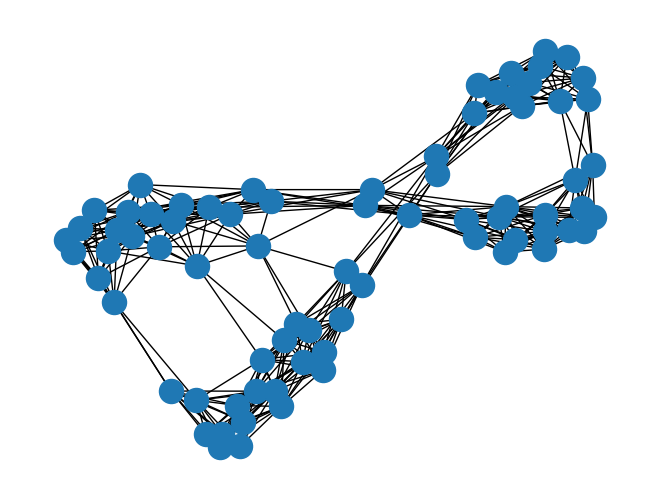

Number of Nodes: 125
Number of Edges: 1250
Max Number of Edges: 7750.0
Ratio:0.16129032258064516


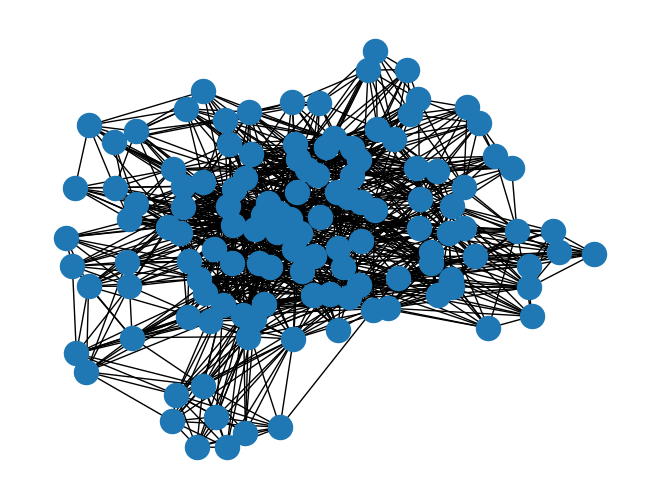

Number of Nodes: 50
Number of Edges: 500
Max Number of Edges: 1225.0
Ratio:0.40816326530612246


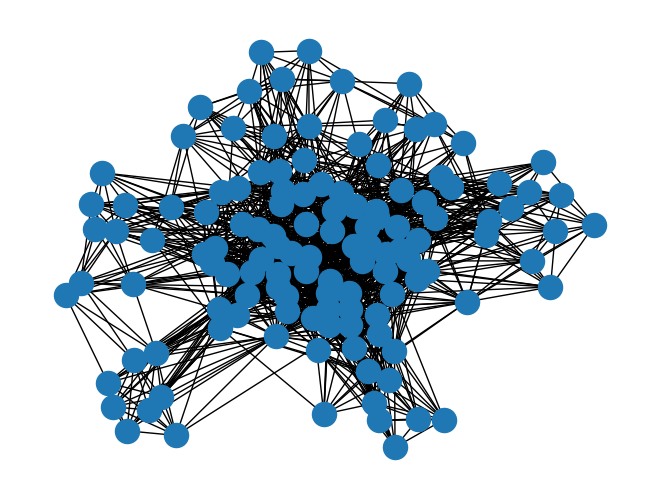

Number of Nodes: 96
Number of Edges: 960
Max Number of Edges: 4560.0
Ratio:0.21052631578947367


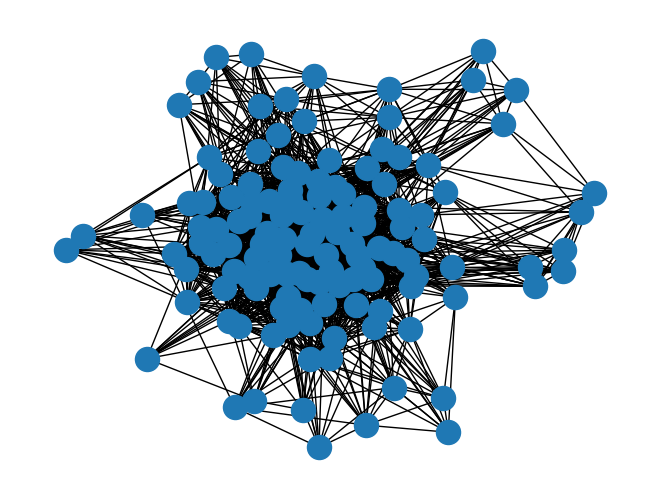

Number of Nodes: 59
Number of Edges: 590
Max Number of Edges: 1711.0
Ratio:0.3448275862068966


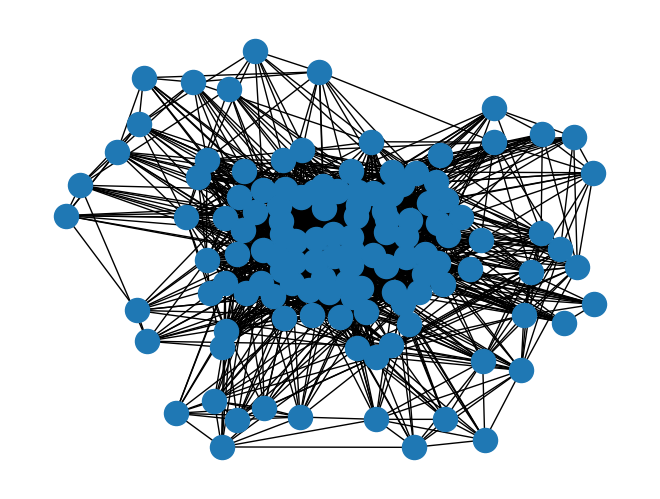

In [7]:
k = 10
file = fileset['sample'][0]
test_threshold(file, k)

In [8]:
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     results = list(executor.map(process_files, fileset['sample']))

In [9]:
# process_files_r(fileset['sample'][0])

In [10]:
# graph = torch.load(file_R)
# total_edges = 0
# total_nodes = 0
# data = graph[0]
# edge_indices = [tuple(tensor.tolist()) for tensor in data.edge_index]
# edge_indices
# # for data in graph:
# #     node_features = data.x
# #     edge_indices = [tuple(tensor.tolist()) for tensor in data.edge_index]
# #     # print(len(edge_indices))
# #     total_edges += len(edge_indices)
# #     total_nodes += len(node_features)

# # print(total_edges/146)
# # print(total_nodes/146)

# # # graph2 = torch.load(file_r)
# # # total_edges = 0
# # # for data in graph2:
# # #     node_features = data.x
# # #     edge_indices = [tuple(tensor.tolist()) for tensor in data.edge_index]
# # #     # print(len(edge_indices))
# # #     total_edges += len(edge_indices)

# # # print(total_edges/146)